## Tutoriel : interagir avec le système de stockage S3 du SSP Cloud (MinIO)

In [55]:
import os

import pandas as pd
import numpy as np
import s3fs
import zipfile
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Récupérer les données d'un challenge

In [56]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [57]:
# Lister les challenges
fs.ls("gvimont/diffusion/hackathon-minarm-2024")

['gvimont/diffusion/hackathon-minarm-2024/AIVSAI',
 'gvimont/diffusion/hackathon-minarm-2024/Acoustique',
 'gvimont/diffusion/hackathon-minarm-2024/Similarité']

In [58]:
# Lister les fichiers d'un challenge
fs.ls("gvimont/diffusion/hackathon-minarm-2024/Acoustique")

['gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip']

In [ ]:
# Télécharger les données dans le service
PATH_IN = 'gvimont/diffusion/hackathon-minarm-2024/Acoustique/LivingRoom_preprocessed_hack.zip'
fs.download(PATH_IN, 'data/LivingRoom_preprocessed_hack.zip')

In [ ]:
# Décompresser les données
with zipfile.ZipFile("data/LivingRoom_preprocessed_hack.zip","r") as zip_file:
    zip_file.extractall("data/")

### Lecture des fichiers

In [59]:
#On récupère la position de l'human dans la pièce à chaque expérience 
human_position = np.load('data/LivingRoom_preprocessed_hack/Human1/centroid.npy')

In [60]:
#On print pour voir comment est stocké la data
#On constate : [[x, y], [x, y],...]
human_position

array([[-3231.3293467 , -1127.87771457],
       [-3198.54107875,  -744.5100656 ],
       [-3192.9776274 ,  -248.26678827],
       ...,
       [-1717.89923578, -3166.59648491],
       [-1808.60337549, -2779.13038427],
       [   44.43741322,   106.48353609]])

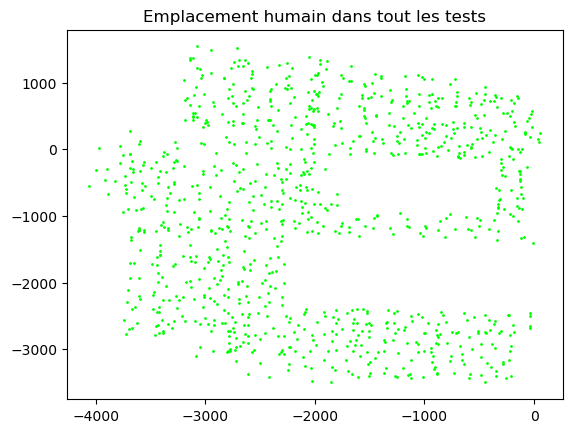

In [61]:
#Montrons avec un graph la répartition des coordonnées de l'humain
#On peut voir des carrés blancs, cela représente par exemple un canapé ou une table
#Où l'humain durant les tests ne pouvait pas se placer
plt.plot([tab_file[0] for tab_file in human_position], [tab_file2[1] for tab_file2 in human_position], linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 1)
plt.title('Emplacement humain dans tout les tests')
plt.show()

In [62]:
#On récupère les données RIR : Room Impulse Response
rir_data = np.load('data/LivingRoom_preprocessed_hack/Human1/deconvoled_trim.npy')
rir_data

array([[[ 9.07240337e-06,  1.71257434e-05,  1.22597794e-05, ...,
          8.86178623e-06,  1.40686043e-05,  1.06616626e-05],
        [-8.23853679e-06, -8.23373648e-06, -8.74563466e-06, ...,
          2.87394778e-06, -8.90485808e-06, -3.52464713e-06],
        [ 6.62780906e-07, -1.40201587e-06,  1.83228190e-06, ...,
         -1.06218545e-06,  8.53497477e-06,  2.28155182e-06],
        [ 8.11119719e-07, -2.47451499e-06,  5.82140547e-06, ...,
          7.73804004e-06,  2.29692650e-05,  1.10566034e-05]],

       [[ 1.64466037e-05,  1.53698293e-05,  1.91599720e-05, ...,
          1.76548729e-05,  1.70955263e-05,  1.41169767e-05],
        [ 1.05826217e-07,  9.13145777e-06,  1.76140716e-07, ...,
          1.21369967e-05,  1.55958387e-05,  1.23088676e-05],
        [ 7.06836090e-06,  3.26818258e-06,  7.15508941e-06, ...,
          4.64980394e-06,  8.96262554e-06,  6.55734584e-06],
        [-3.18089551e-05, -8.93297238e-06, -2.51026504e-05, ...,
         -7.02741545e-07,  1.34268867e-05,  3.24307

In [63]:
print(rir_data.shape[2])
num_rows = rir_data.shape[2]
thirty_percent_index = int(0.1425 * num_rows)
rir = rir_data[:, :, :thirty_percent_index]
print(rir.shape)

667200
(1000, 4, 95075)


In [64]:
#Regardons plus en détail la data rir
len(rir[0])
print(" ")
len(rir[0][0])

print(rir[0])
print(len(rir[0][0]))

 
[[ 9.07240337e-06  1.71257434e-05  1.22597794e-05 ...  6.07175480e-07
   8.07913784e-06  2.63215702e-06]
 [-8.23853679e-06 -8.23373648e-06 -8.74563466e-06 ... -1.25719325e-05
  -4.46412650e-06 -9.04755234e-06]
 [ 6.62780906e-07 -1.40201587e-06  1.83228190e-06 ...  5.64338052e-06
  -2.80980248e-06  1.05892505e-05]
 [ 8.11119719e-07 -2.47451499e-06  5.82140547e-06 ...  3.88955277e-06
   1.03303637e-05  3.50578830e-06]]
95075


Le block juste en dessous est la méthode RMS. Bien qu'elle soit utilisable pour le KNN et a de meilleurs résultats
(très léger, on a 108cm de Moyenne des distances euclidiennes, contre 133cm par SoundCam) que le KNN du rapport de SoundCam.
La méthode utilisant PCA (juste en dessous de RMS) est bien meilleure, donc nous allons l'utiliser à la place de RMS

In [ ]:
#On applique la méthode RMS, pour Root Mean Square
#Qui permet de donner la moyenne de l'amplitude des sons de rir en 1 seule donnée
#RMS_levels = np.sqrt(np.mean(rir**2, axis=2))
#print(RMS_levels)

In [65]:
from sklearn.decomposition import PCA

#On applique la méthode PCA sur RIR
#Le but est de projeter des données multidimensionnelles dans un espace de dimensions plus petites 
#Tout en conservant autant d'information que possible
X_reshaped = rir.reshape(1000, -1)
pca = PCA(n_components=100)
RMS_levels = pca.fit_transform(X_reshaped)
print(RMS_levels)

[[ 0.07737584 -0.2583668   0.36190844 ...  0.00280634 -0.00635565
  -0.00607803]
 [ 0.07211538 -0.2706036   0.32961178 ... -0.00391542  0.00686049
  -0.00078889]
 [ 0.06027099 -0.25214216  0.35522658 ...  0.00194708  0.00568298
  -0.01223831]
 ...
 [-0.24986285  0.45532036  0.11053555 ...  0.00294277 -0.00398163
   0.00918889]
 [-0.24893387  0.43469617  0.09012294 ... -0.0020237  -0.00603973
   0.0010488 ]
 [-0.03933972  0.38739407  0.03116314 ...  0.00570158  0.01267207
   0.00591774]]


In [66]:
#On normalise les RMS pour le KNN
#On utilise le StandardScaler
print(RMS_levels.shape)
scaler = StandardScaler()
normalized_RMS = scaler.fit_transform(RMS_levels)
print(normalized_RMS)

(1000, 100)
[[ 0.22372074 -1.0367994   1.7458636  ...  0.2325565  -0.5326091
  -0.5146299 ]
 [ 0.20851089 -1.0859045   1.590063   ... -0.32446352  0.5749165
  -0.06679618]
 [ 0.17426461 -1.0118207   1.71363    ...  0.16135143  0.47623965
  -1.0362234 ]
 ...
 [-0.72244126  1.8271539   0.53322875 ...  0.24386248 -0.33366388
   0.778027  ]
 [-0.71975523  1.7443912   0.43475732 ... -0.16769989 -0.50613475
   0.08880195]
 [-0.11374494  1.5545727   0.15033245 ...  0.4724798   1.0619321
   0.501058  ]]


In [67]:
#On divise les données en données d'entrainement pour notre Knn
#Et en donnée de test pour tester notre entrainement de Knn pour voir si il arrive bien à prédire
#On prend 80% d'entrainement et 20% de test
X_train, X_test, y_train, y_test = train_test_split(normalized_RMS, human_position, test_size=0.2, random_state=42)

In [68]:
#On initialise notre Knn en prenant en compte 2 voisins
k = 2
knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2, weights='distance')

In [69]:
#Avec notre Knn, on essaye de prédire la position de l'humain sur toutes les données de test
#predicted_position = knn.predict(query_RMS)
predicted_position = knn.predict(X_test)
print("Predicted human position:", predicted_position)

Predicted human position: [[-1077.65013136   200.93585597]
 [-2281.33586832 -1070.65935894]
 [ -981.55903641 -1063.33550853]
 [-2648.97259088 -2730.24034307]
 [-1814.28968214 -2510.7710153 ]
 [-2586.44300201   849.11595535]
 [-1467.39838165 -2800.29439084]
 [ -851.62034374   327.86842097]
 [-1186.9778922  -3358.48568348]
 [ -526.6614109    671.77118066]
 [  -22.79009368   556.67618734]
 [-2678.61875188  -453.46288884]
 [-1276.88118013 -2970.3867714 ]
 [-1504.24344681 -2716.44368766]
 [ -410.19732476 -2733.47258627]
 [-3552.34613232  -236.29451765]
 [-1592.32435127   -61.31000467]
 [-1580.92317137   268.40372557]
 [-2553.13369293 -2297.03800982]
 [-3603.36574386 -1776.38722892]
 [-3438.23297291 -2502.13309505]
 [ -236.64768467  -124.98386117]
 [-3117.96088268  -391.3813102 ]
 [-1328.20123949   660.98968689]
 [-1001.32026239 -1197.78377547]
 [-2531.24169589 -2491.43670464]
 [-2088.39458147   960.47854616]
 [-1570.26176209 -3026.08306167]
 [-3596.52753075   -83.44713854]
 [ -763.93592017 

In [70]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

mse = mean_squared_error(y_test, predicted_position)
mae = mean_absolute_error(y_test, predicted_position)
r2 = r2_score(y_test, predicted_position)

print("Test MSE : ", mse)
print("Test MAE : ", mae)
print("Test R2 : ", r2)

Test MSE :  321917.596233365
Test MAE :  339.5499557254788
Test R2 :  0.785211540936765


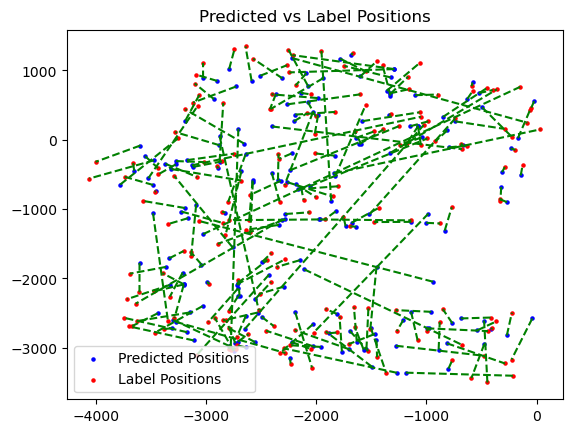

In [71]:
#On montre un graph représentant la chambre, avec :
# - En point bleu, les positions humaines que notre Knn à prédit
# - En point rouge, les vraies positions des humains dans chaque test
# - Les lignes vertes connectent la valeur prédite à son label
plt.scatter(predicted_position[:, 0], predicted_position[:, 1], color='blue', label='Predicted Positions', s=5)
plt.scatter(y_test[:, 0], y_test[:, 1], color='red', label='Label Positions', s=5)
for i in range(len(predicted_position)):
    plt.plot([predicted_position[i][0], y_test[i][0]], [predicted_position[i][1], y_test[i][1]], color='green', linestyle='--')
plt.title('Predicted vs Label Positions')
plt.legend()
plt.show()

In [72]:
#Donne le pourcentage de bon résultat en fonction d'une intervalle
#L'intervalle définit le degré d'acceptation pour dire si la coordonée prédite est la même que celle du test
#Par exemple, avec un intervalle de 500, on accepte que la coordonée puisse être à 50cm d'écart maximum de celle initiale
good_result = 0
intervalle = 500
for i in range(0, len(predicted_position)):
    if predicted_position[i][0] > y_test[i][0] - intervalle and predicted_position[i][0] < y_test[i][0] + intervalle:
        if predicted_position[i][1] > y_test[i][1] - intervalle and predicted_position[i][1] < y_test[i][1] + intervalle:
            good_result += 1

print("Le pourcentage de bonnes prédictions est de : " + str(good_result / len(predicted_position)))

Le pourcentage de bonnes prédictions est de : 0.71


In [73]:
#Donne la distance Euclidienne moyenne entre les labels et les valeurs prédite en mm
def euclidean_distance(predicted_position, y_test):
    diff = y_test - predicted_position
    dist = np.linalg.norm(diff, axis=1)
    return dist

disst = euclidean_distance(y_test, predicted_position)
mean_dist = np.mean(disst)

print(mean_dist)

542.9278893658276


Ici, avec PCA, on a une moyenne de distance euclidienne de 54,2cm.
Comme on le voit sur le document de SoundCam, pour la chambre LivingRoom, ils ont une distance moyenne de 170cm
Notre modèle est donc bien plus efficace que le leurs

In [74]:
neighbors = np.arange(1, 20)
test_accuracy = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    predicted_position = knn.predict(X_test)
    test_accuracy[i] = np.mean(euclidean_distance(predicted_position, y_test))

print(test_accuracy)

[582.82014517 542.92788937 558.95072292 558.65672366 603.64593792
 627.89613576 667.36437513 696.37491863 721.0809392  736.73731884
 764.21594871 788.0966852  810.97002589 831.9540344  844.75501175
 862.63140485 886.81547165 907.13151913 919.05615467]


Faisons avec la base de donnée Human2 et Human1 concaténée
Vu que c'est concrètement la même chose que Human1, je vais cela qu'en 2 blocks

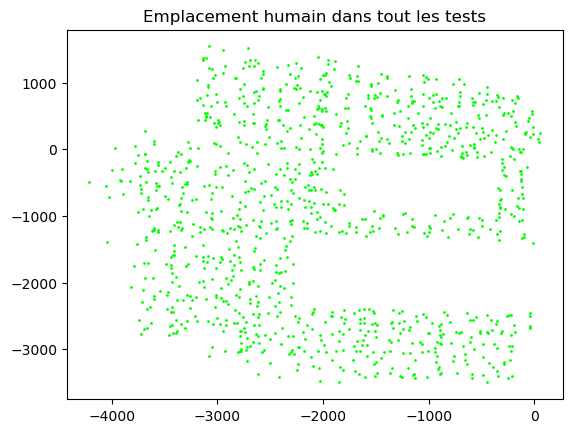

667200
(1104, 4, 95075)
[[ 0.11390948 -0.23327711  0.38183028 ... -0.00344852  0.00840791
   0.0041403 ]
 [ 0.11081492 -0.2509863   0.34919816 ... -0.00172842 -0.00177998
   0.00469065]
 [ 0.09593163 -0.2274238   0.37664288 ... -0.01417796  0.01257023
  -0.00251385]
 ...
 [-0.11178308  0.25856453  0.19803743 ... -0.0033862  -0.00612229
  -0.00444874]
 [-0.10887266  0.2533743   0.20186608 ... -0.00299305 -0.00968594
   0.00375286]
 [-0.10697407  0.25332576  0.21153682 ... -0.00108604 -0.01138984
   0.00847229]]
(1104, 100)
[[ 0.3400666  -0.9233063   1.9010714  ... -0.27493042  0.6749734
   0.33361074]
 [ 0.3308281  -0.99339885  1.7386013  ... -0.1377968  -0.14289407
   0.37795582]
 [ 0.28639537 -0.900139    1.8752441  ... -1.1303252   1.0091182
  -0.2025565 ]
 ...
 [-0.33371836  1.0233933   0.9859964  ... -0.26996142 -0.4914878
  -0.3584631 ]
 [-0.32502955  1.0028505   1.0050586  ... -0.23861833 -0.7775717
   0.30239183]
 [-0.31936148  1.0026584   1.0532078  ... -0.08658317 -0.9143578
 

In [79]:
#On récupère la position de l'human dans la pièce à chaque expérience 
human_position2 = np.load('data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
human_position_true = np.concatenate((human_position, human_position2), axis=0)
#Montrons avec un graph la répartition des coordonnées de l'humain
#On peut voir des carrés blancs, cela représente par exemple un canapé ou une table
#Où l'humain durant les tests ne pouvait pas se placer
plt.plot([tab_file[0] for tab_file in human_position_true], [tab_file2[1] for tab_file2 in human_position_true], linestyle = 'none', marker = 'o', c = 'lime',
  markersize = 1)
plt.title('Emplacement humain dans tout les tests')
plt.show()
#On récupère les données RIR : Room Impulse Response
rir_data2 = np.load('data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy')
rir_data_true = np.concatenate((rir_data, rir_data2), axis=0)
print(rir_data_true.shape[2])
num_rows = rir_data_true.shape[2]
thirty_percent_index = int(0.1425 * num_rows)
rir2 = rir_data_true[:, :, :thirty_percent_index]
print(rir2.shape)
#On applique la méthode PCA sur RIR
#Le but est de projeter des données multidimensionnelles dans un espace de dimensions plus petites 
#Tout en conservant autant d'information que possible
X_reshaped2 = rir2.reshape(1104, -1)
pca2 = PCA(n_components=100)
RMS_levels2 = pca2.fit_transform(X_reshaped2)
print(RMS_levels2)
#On normalise les RMS pour le KNN
#On utilise le StandardScaler
print(RMS_levels2.shape)
#RMS3 = RMS_levels2.reshape(104, -1)
scaler2 = StandardScaler()
normalized_RMS2 = scaler.fit_transform(RMS_levels2)
print(normalized_RMS2)

1104
Test MSE :  214184.11735149243
Test MAE :  293.88915276304647
Test R2 :  0.8508266427533435


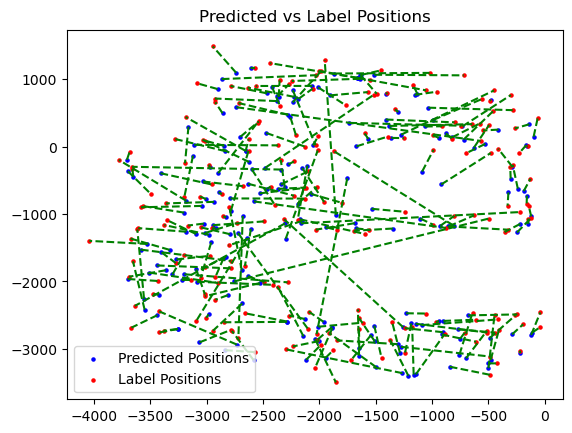

484.3716924026952


In [80]:
#On divise les données en données d'entrainement pour notre Knn
#Et en donnée de test pour tester notre entrainement de Knn pour voir si il arrive bien à prédire
#On prend 80% d'entrainement et 20% de test
print(len(normalized_RMS2))
X_train2, X_test2, y_train2, y_test2 = train_test_split(normalized_RMS2, human_position_true, test_size=0.2)
#On initialise notre Knn en prenant en compte 2 voisins
k2 = 2
knn2 = KNeighborsRegressor(n_neighbors=k2, weights='distance')
knn2.fit(X_train2, y_train2)
#Avec notre Knn, on essaye de prédire la position de l'humain sur toutes les données de test
#predicted_position = knn.predict(query_RMS)
predicted_position2 = knn2.predict(X_test2)
mse2 = mean_squared_error(y_test2, predicted_position2)
mae2 = mean_absolute_error(y_test2, predicted_position2)
r22 = r2_score(y_test2, predicted_position2)

print("Test MSE : ", mse2)
print("Test MAE : ", mae2)
print("Test R2 : ", r22)

#On montre un graph représentant la chambre, avec :
# - En point bleu, les positions humaines que notre Knn à prédit
# - En point rouge, les vraies positions des humains dans chaque test
# - Les lignes vertes connectent la valeur prédite à son label
plt.scatter(predicted_position2[:, 0], predicted_position2[:, 1], color='blue', label='Predicted Positions', s=5)
plt.scatter(y_test2[:, 0], y_test2[:, 1], color='red', label='Label Positions', s=5)
for i in range(len(predicted_position2)):
    plt.plot([predicted_position2[i][0], y_test2[i][0]], [predicted_position2[i][1], y_test2[i][1]], color='green', linestyle='--')
plt.title('Predicted vs Label Positions')
plt.legend()
plt.show()

disst2 = euclidean_distance(y_test2, predicted_position2)
mean_dist2 = np.mean(disst2)

print(mean_dist2)

Grace à la concaténation des 2 datasets, on constate une petite amélioration sur le R2, mais aussi sur la moyenne de distance euclidienne qui passe de 56,6cm à 48,4cm